#Exercise 6
This notebook shows 4 examples of neural networks build with keras and tensorflow.
It also compares accuracy of Iris dataset tested in previous exercise.

Next two cells are code with implementations of all the custom classes

In [1]:
from abc import ABC, abstractmethod, abstractproperty

import sys
from typing import Tuple, Any

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import tensorflow as tf
import requests

class TensorflowBasedNN(ABC):
    @property
    def name(self) -> str:
        return self.__class__.__name__

    def __init__(self):
        self.model = None
        (self.train_data, self.train_labels), (
            self.test_data,
            self.test_labels,
        ) = self.provide_data()

    @abstractmethod
    def provide_data(self) -> Tuple[Tuple[Any], Tuple[Any]]:
        """abstract method that needs to be implemented.
        it should return data in form (train_data, train_labels), (test_data, test_labels)
        that will be used to train and evaluate model
        """
        ...

    @abstractmethod
    def train(self, epochs: int):
        """abstract method that needs to be implemented (should implement "epochs" argument).
        it has to train model (so has to call model.compile and model.fit methods)
        """
        ...

    def evaluate(self) -> float:
        """method to compute accuracy of model

        Returns:
            float: accuracy of model
        """
        _, test_acc = self.model.evaluate(self.test_data, self.test_labels, verbose=2)
        return test_acc

    def to_keras_model(self, path: str):
        """helper method to save model as keras model

        Args:
            path (str): path where model should be saved
        """
        tf.keras.models.save_model(self.model, path)

    @classmethod
    def from_keras_model(cls, path: str) -> "TensorflowBasedNN":
        """helper method to load keras model

        Args:
            path (str): path where model is saved

        Returns:
            TensorflowBasedNN: [description]
        """
        klass = cls()
        klass.model = tf.keras.models.load_model(path)
        return klass


class TensorflowBasedNNWithImages(TensorflowBasedNN):
    @property
    @abstractmethod
    def all_classes(self) -> list:
        """abstract property that has to be implemented
            it has to return list with all the classes of data
            it is used for show_image method to set labels


        Returns:
            list: all the classes of data
        """
        ...

    def show_image(self, idx: int, from_test_data=True):
        """method to show image using matplotlib

        Args:
            idx (int): index of image to be shown
            from_test_data (bool, optional): determines if should show image from test or train data. Defaults to True.
        """
        image = self.train_data[idx] if from_test_data else self.test_data[idx]
        label = self.train_labels[idx] if from_test_data else self.test_labels[idx]

        try:
            if not isinstance(label, int):
                label = label[0]
        except:
            pass

        plt.figure()
        plt.imshow(image)
        plt.colorbar()
        plt.grid(False)
        plt.xlabel(self.all_classes[label])
        plt.show()


class Iris(TensorflowBasedNN):
    """Neural network for Iris dataset (taken from sklearn)
    adapted from https://www.kaggle.com/zahoorahmad/tensorflow-and-keras-on-iris-dataset
    """

    def provide_data(self):
        """method to get Iris dataset from sklearn API

        Returns:
            Tuple: tuple with Iris dataset
        """
        data = load_iris()
        x_train, x_test, y_train, y_test = train_test_split(
            data.data, data.target, test_size=0.1
        )
        return (x_train, y_train), (x_test, y_test)

    def train(self, epochs=50):
        """method to train Iris model

        Args:
            epochs (int, optional): epochs to train model. Defaults to 50.
        """
        self.model = tf.keras.models.Sequential(
            [
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(512, activation=tf.nn.relu),
                tf.keras.layers.Dropout(0.2),
                tf.keras.layers.Dense(10, activation=tf.nn.softmax),
            ]
        )
        self.model.compile(
            optimizer="adam",
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"],
        )

        self.model.fit(self.train_data, self.train_labels, epochs=epochs)


class FashionMnist(TensorflowBasedNNWithImages):
    """Neural network for FashionMNIST dataset
    adapted from https://www.tensorflow.org/tutorials/keras/classification
    """

    @property
    def all_classes(self):
        """property list with all the FashionMNIST classes

        Returns:
            list: list with all the FashionMNIST classes
        """
        return [
            "T-shirt/top",
            "Trouser",
            "Pullover",
            "Dress",
            "Coat",
            "Sandal",
            "Shirt",
            "Sneaker",
            "Bag",
            "Ankle boot",
        ]

    def provide_data(self) -> Tuple[Tuple[Any], Tuple[Any]]:
        """method to get FashionMNIST dataset from keras API

        Returns:
            Tuple: tuple with FashionMNIST dataset
        """
        fashion_mnist = tf.keras.datasets.fashion_mnist
        return fashion_mnist.load_data()

    def train(self, epochs=10):
        """method to train FashionMNIST model

        Args:
            epochs (int, optional): epochs to train model. Defaults to 10.
        """
        self.train_data = self.train_data / 255.0
        self.test_data = self.test_data / 255.0

        self.model = tf.keras.Sequential(
            [
                tf.keras.layers.Flatten(input_shape=(28, 28)),
                tf.keras.layers.Dense(128, activation="relu"),
                tf.keras.layers.Dense(10),
            ]
        )

        self.model.compile(
            optimizer="adam",
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=["accuracy"],
        )
        self.model.fit(self.train_data, self.train_labels, epochs=epochs)


class Cifar10(TensorflowBasedNNWithImages):
    """Neural network for Cifar10 dataset
    adapted from https://www.tensorflow.org/tutorials/images/cnn
    """

    @property
    def all_classes(self) -> list:
        """property list with all the Cifar10 classes

        Returns:
            list: list with all the Cifar10 classes
        """
        return [
            "airplane",
            "automobile",
            "bird",
            "cat",
            "deer",
            "dog",
            "frog",
            "horse",
            "ship",
            "truck",
        ]

    def provide_data(self) -> Tuple[Tuple[Any], Tuple[Any]]:
        """method to get Cifar10 dataset from keras API

        Returns:
            Tuple: tuple with Cifar10 dataset
        """
        return tf.keras.datasets.cifar10.load_data()

    def train(self, epochs=10):
        """method to train Cifar10 model

        Args:
            epochs (int, optional): epochs to train model. Defaults to 10.
        """
        self.train_data = self.train_data / 255.0
        self.test_data = self.test_data / 255.0

        self.model = tf.keras.Sequential(
            [
                tf.keras.layers.Conv2D(
                    32, (3, 3), activation="relu", input_shape=(32, 32, 3)
                ),
                tf.keras.layers.MaxPooling2D((2, 2)),
                tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
                tf.keras.layers.MaxPooling2D((2, 2)),
                tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(64, activation="relu"),
                tf.keras.layers.Dense(10),
            ]
        )

        self.model.compile(
            optimizer="adam",
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=["accuracy"],
        )

        self.model.fit(self.train_data, self.train_labels, epochs=epochs)


class Imdb(TensorflowBasedNN):
    """Neural network for IMDB dataset
    adapted from https://builtin.com/data-science/how-build-neural-network-keras
    NUM_WORDS define how many words we want to take from this dataset
    """

    NUM_WORDS = 10000

    @staticmethod
    def _vectorize(sequences, dimension: int):
        results = np.zeros((len(sequences), dimension))

        for i, sequence in enumerate(sequences):
            results[i, sequence] = 1

        return results

    def provide_data(self) -> Tuple[Tuple[Any], Tuple[Any]]:
        """method to get IMDB dataset from keras API

        Returns:
            Tuple[Tuple[Any], Tuple[Any]]: tuple with IMDB dataset
        """
        (training_data, training_targets), (
            testing_data,
            testing_targets,
        ) = tf.keras.datasets.imdb.load_data(num_words=self.NUM_WORDS)

        data = np.concatenate((training_data, testing_data), axis=0)
        targets = np.concatenate((training_targets, testing_targets), axis=0)
        data = self._vectorize(data, self.NUM_WORDS)
        targets = np.array(targets).astype("float32")
        test_x = data[: self.NUM_WORDS]
        test_y = targets[: self.NUM_WORDS]
        train_x = data[self.NUM_WORDS :]
        train_y = targets[self.NUM_WORDS :]

        return (train_x, train_y), (test_x, test_y)

    def train(self, epochs=2):
        """method to train IMDB model

        Args:
            epochs (int, optional): epochs to train model. Defaults to 2.
        """
        self.model = tf.keras.models.Sequential(
            [
                tf.keras.layers.Dense(
                    50, activation="relu", input_shape=(self.NUM_WORDS,)
                ),
                tf.keras.layers.Dense(50, activation="relu"),
                tf.keras.layers.Dropout(0.2, noise_shape=None, seed=None),
                tf.keras.layers.Dense(50, activation="relu"),
                tf.keras.layers.Dense(1, activation="sigmoid"),
            ]
        )
        self.model.compile(
            optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"]
        )
        self.model.fit(
            self.train_data,
            self.train_labels,
            epochs=epochs,
            batch_size=500,
        )


In [2]:
# Simple API for classification experiments
# Author: Kacper Wojtasiński

from collections import UserDict
from datetime import datetime
import json
from typing import List, Tuple

import click

import pandas as pd
import numpy as np

from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier


class MachineLearningExperimentResults(UserDict):
    def __init__(self, name: str, classifier_name: str, data: dict):
        """this is class to present results for MachineLearningExperiments
            it subclasses UserDict, so it behave similarily to dict ("get" method, etc.)
            Each dataset needs to have float/int values (except for y-column)
            Each dataset needs to have y-column as the last one
        Args:
            name (str): name of the experiment
            classifier_name (str): name of the used classifier
            data (dict): results of experiment
        """
        super().__init__(data)
        self.data["name"] = name
        self.data["classifier_name"] = classifier_name
        self.data["date"] = str(datetime.now())

        self.name = name
        self.classifier = classifier_name
        self.right = self.data.get("right")
        self.wrong = self.data.get("wrong")
        self.score = self.data.get("score")
        self.date = self.data.get("date")

    def _validate_comparison(self, other: "MachineLearningExperimentResults"):
        """it validates other - object we want to compare to
            object must be of type MachineLearningExperimentResults and have the same name

        Args:
            other (MachineLearningExperimentResults): object to compare to

        Raises:
            TypeError: if given object is not of type MachineLearningExperimentResults
            ValueError: if given MachineLearningExperimentResults's name is not the same as ours
        """
        if type(other) != type(self):
            raise TypeError(
                f'Comparison makes sense only for "{self.__class__.__name__}" type'
            )

        if self.name != other.name:
            raise ValueError(
                f'Comparison makes sense only for results for the same experiments. Comparing "{self.name}" with "{other.name}"'
            )

    def __lt__(self, other: "MachineLearningExperimentResults"):
        self._validate_comparison(other)

        return self.score < other.score

    def __gt__(self, other: "MachineLearningExperimentResults"):
        self._validate_comparison(other)

        return self.score > other.score

    def __str__(self):
        return f"{self.__class__.__name__} (name={self.name}, date={self.date}, classifier_name={self.classifier}, right={len(self.right)}, wrong={len(self.wrong)}, score={self.score})"

    def __repr__(self):
        return str(self)

    def to_json(self, path_to_json: str):
        """ method to save this class as a JSON file

        Args:
            path_to_json (str): path to created file
        """
        with open(path_to_json, "w") as _f:
            json.dump(self.data, _f)


class MachineLearningExperiment:
    def __init__(
        self, name: str, dataframe: pd.DataFrame, test_size=0.1, train_size=0.9
    ):
        """this is class to perform simple machine learning experiments using scikit-learn
            it requires that the last column of dataframe has the Y-values

        Args:
            name (str): name of the experiment
            dataframe (pd.DataFrame): dataframe with data
            test_size (float, optional): size of test set. Defaults to 0.1.
            train_size (float, optional): size of train set. Defaults to 0.9.
        """
        self.name = name
        self.classifiers = {}
        self.df = dataframe
        (
            self.X_train,
            self.X_test,
            self.y_train,
            self.y_test,
        ) = self._divide_into_test_train(test_size, train_size)

    def __str__(self):
        return f"{self.__class__.__name__} (name={self.name}, classifiers={list(self.classifiers.keys())}, X_train={len(self.X_train)}, X_test={len(self.X_test)}, y_train={len(self.y_train)}, y_test={len(self.y_test)})"

    @classmethod
    def from_csv(
        cls, name: str, csv_file_path: str, test_size=0.1, train_size=0.9
    ) -> "MachineLearningExperiment":
        return cls(name, pd.read_csv(csv_file_path), test_size, train_size)

    def _raise_if_classifier_does_not_exist(self, classifier_name: str):
        """helper method to raise exception when classifier with given name
            is not available

        Args:
            classifier_name (str): name of classifier

        Raises:
            ValueError: when classifier is not available
        """
        if classifier_name not in self.classifiers:
            raise ValueError(f"{classifier_name} classifier is not present")

    def _divide_into_test_train(
        self, test_size: int, train_size: int
    ) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
        """helper method to split data into test and train sets

        Args:
            test_size (int): size of test set
            train_size (int): size of train set

        Returns:
            Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]: tuple with dataframes for all the subsets
        """
        X_train, X_test, y_train, y_test = train_test_split(
            self.df.iloc[:, :-1],
            self.df.iloc[:, -1],
            test_size=test_size,
            train_size=train_size,
        )
        return X_train, X_test, y_train, y_test

    def setup_svm(self, classifier_name="SVM", **kwargs):
        """method to setup SVM classifier.
            you can override classifier_name to compare different sets of kwargs
            all the kwargs will be provided to the scikit-learn classifier constructor

        Args:
            classifier_name (str, optional): [description]. Defaults to 'SVM'.
        """
        if not classifier_name in self.classifiers:
            clf = svm.SVC(**kwargs)
            clf.fit(self.X_train, self.y_train)
            self.classifiers[classifier_name] = clf

    def setup_ada(self, classifier_name="ADA", **kwargs):
        """method to setup ADA classifier.
            you can override classifier_name to compare different sets of kwargs
            all the kwargs will be provided to the scikit-learn classifier constructor

        Args:
            classifier_name (str, optional): [description]. Defaults to 'ADA'.
        """
        if not classifier_name in self.classifiers:
            clf = AdaBoostClassifier(**kwargs)
            clf.fit(self.X_train, self.y_train)
            self.classifiers[classifier_name] = clf

    def predict(self, classifier_name: str, _input: list) -> pd.Series:
        """method to predict output of given values

        Args:
            classifier_name (str): name of classifier to be used
            _input (list): values to be used to predict

        Returns:
            pd.Series: results
        """
        self._raise_if_classifier_does_not_exist(classifier_name)

        clf = self.classifiers.get(classifier_name)

        return pd.Series(clf.predict(_input))

    def get_results(self, classifier_name: str) -> MachineLearningExperimentResults:
        """method to get results for classifier with given name.
            it evaluates model with y_test

        Args:
            classifier_name (str): name of the classifer

        Returns:
            MachineLearningExperimentResults: results
        """
        self._raise_if_classifier_does_not_exist(classifier_name)

        results_dict = {"right": [], "wrong": [], "score": 0}
        predictions = self.predict(classifier_name, self.X_test)
        turn_pandas_series_into_list = lambda idx: self.X_test.iloc[idx, :].tolist()

        for idx, (predicted, truth) in enumerate(zip(predictions, self.y_test)):
            if predicted == truth:
                results_dict["right"].append(
                    {
                        "data": turn_pandas_series_into_list(idx),
                        "predicted": predicted,
                        "truth": truth,
                    }
                )
                results_dict["score"] += 1
            else:
                results_dict["wrong"].append(
                    {
                        "data": turn_pandas_series_into_list(idx),
                        "predicted": predicted,
                        "truth": truth,
                    }
                )

        results_dict["score"] /= len(self.y_test)

        return MachineLearningExperimentResults(
            self.name, classifier_name, results_dict
        )

    def get_results_for_all_classifiers(
        self, _sorted=True, reverse=True
    ) -> List[MachineLearningExperimentResults]:
        """method to prepare list of results for all the classifiers
           it runs get_results for all of them

        Args:
            _sorted (bool, optional): determines if list should be sorted by score. Defaults to True.
            reverse (bool, optional): determines if list should be sorted in descending order. Defaults to True.

        Returns:
            List[MachineLearningExperimentResults]: list with results
        """
        results = [
            self.get_results(classifier_name)
            for classifier_name in self.classifiers.keys()
        ]

        if _sorted:
            return sorted(results, reverse=reverse)

        return results


In [3]:
# helper function to print accuracy of mode
def print_accuracy(model: TensorflowBasedNN):
  print(f"{model.__class__.__name__} model has {model.evaluate()} accuracy")

In [4]:
# preparing Iris model
iris = Iris()

# training Iris model
iris.train(epochs=50)

# evaluation of Iris model
print_accuracy(iris)

# download Iris dataset for MachineLearningExperiment
_file = requests.get('https://gist.githubusercontent.com/curran/a08a1080b88344b0c8a7/raw/0e7a9b0a5d22642a06d3d5b9bcbad9890c8ee534/iris.csv')
with open('iris.csv', 'w') as _f:
  _f.write(_file.text)

# prepare Iris experiment
iris_experiment = MachineLearningExperiment.from_csv('iris', 'iris.csv')

# setup SVM classifier
iris_experiment.setup_svm()

# accuracy of Iris experiment
print(f"Results for {iris_experiment}: {iris_experiment.get_results('SVM').score}")

Epoch 1/50
5/5 [==============================] - 0s 4ms/step - loss: 2.3077 - accuracy: 0.2783
Epoch 2/50
5/5 [==============================] - 0s 2ms/step - loss: 1.5522 - accuracy: 0.4209
Epoch 3/50
5/5 [==============================] - 0s 2ms/step - loss: 1.1680 - accuracy: 0.3989
Epoch 4/50
5/5 [==============================] - 0s 2ms/step - loss: 0.9887 - accuracy: 0.5044
Epoch 5/50
5/5 [==============================] - 0s 2ms/step - loss: 0.9026 - accuracy: 0.5931
Epoch 6/50
5/5 [==============================] - 0s 2ms/step - loss: 0.7947 - accuracy: 0.6964
Epoch 7/50
5/5 [==============================] - 0s 2ms/step - loss: 0.7523 - accuracy: 0.6746
Epoch 8/50
5/5 [==============================] - 0s 2ms/step - loss: 0.6997 - accuracy: 0.6928
Epoch 9/50
5/5 [==============================] - 0s 2ms/step - loss: 0.6456 - accuracy: 0.7239
Epoch 10/50
5/5 [==============================] - 0s 3ms/step - loss: 0.5650 - accuracy: 0.8007
Epoch 11/50
5/5 [======================

In [5]:
# preparing Cifar10 model
cifar = Cifar10()

# training Cifar10 model
cifar.train(epochs=1)

# evaluation of Cifar10 model
print_accuracy(cifar)


1563/1563 [==============================] - 56s 35ms/step - loss: 1.7347 - accuracy: 0.3582
313/313 - 3s - loss: 1.2854 - accuracy: 0.5374
Cifar10 model has 0.5374000072479248 accuracy


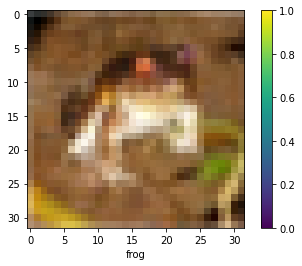

In [6]:
# showing picture from cifar
cifar.show_image(0)

In [7]:
# preparing FashionMnist model
mnist = FashionMnist()

# training FashionMnist model
mnist.train()

# evaluation of FashionMnist model
print_accuracy(mnist)

Epoch 1/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.6343 - accuracy: 0.7776
Epoch 2/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3868 - accuracy: 0.8643
Epoch 3/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3395 - accuracy: 0.8758
Epoch 4/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3194 - accuracy: 0.8839
Epoch 5/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2954 - accuracy: 0.8918
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2859 - accuracy: 0.8952
Epoch 7/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2701 - accuracy: 0.8989
Epoch 8/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2574 - accuracy: 0.9046
Epoch 9/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2410 - accuracy: 0.9107
Epoch 10/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.240

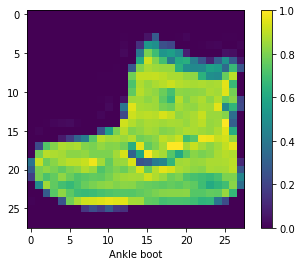

In [8]:
mnist.show_image(0)

In [9]:
# preparing IMDB model
imdb = Imdb()

# training IMDB model
imdb.train()

# evaluation of IMDB model
print_accuracy(imdb)

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

Epoch 1/2
80/80 [==============================] - 3s 30ms/step - loss: 0.5104 - accuracy: 0.7387
Epoch 2/2
80/80 [==============================] - 2s 28ms/step - loss: 0.2061 - accuracy: 0.9246
313/313 - 1s - loss: 0.2738 - accuracy: 0.8918
Imdb model has 0.8917999863624573 accuracy
